# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

## Цели работы:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


Уровень статистической значимости - ***0,05***

## 1. Загрузка и обработка данных

1.1 Импортируем библиотеки и датасет, задаём уровень значимости

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings( 'ignore' )
from scipy import stats

In [2]:
main_data = pd.read_csv('data/ds_salaries.csv')

In [3]:
alpha = 0.05

1.2 Проверка на наличие пропусков и дубликатов, корректность типов данных

In [4]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


*Датасет содержит *12* признаков по *607* строк, пропусков не имеет. Содержит три явно неинформативных признака "Unnamed: 0", "salary", "salary_currency". Датасет содержит четыре числовых признака:*

- год работы,
- зарплата,
- зарплата в долларах,
- объём работы выполняемой удалённо

- Остальные признаки категориальные

 *Типы данных в признаках выглядят корректно, за исключением признака год работы, **возможно** придётся перевести его в формат datetime*

* Удалим неинформативный признак и проверим датасет на наличие дубликатов, удалим их в случае нахождения

In [5]:
main_data = main_data.drop(
    columns=['Unnamed: 0', 'salary_currency', 'salary'],
    axis=1
    )

In [6]:
print(f'Общее количество строк : {main_data.shape[0]}')
print(f'Количество полных дубликатов : {main_data[main_data.duplicated()].shape[0]}')
main_data = main_data.drop_duplicates()
print(f'Количество строк после удаления дубликатов: {main_data.shape[0]}')

Общее количество строк : 607
Количество полных дубликатов : 42
Количество строк после удаления дубликатов: 565


* Посмотрим на информативность признаков

In [7]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in main_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = main_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = main_data[col].nunique() / main_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
        
main_data = main_data.drop('employment_type', axis=1)

employment_type: 96.64% одинаковых значений


*Признак "тип трудоустройства" имеет > 96% одинаковых значений, он не будет учавствовать в исследовании*

* Посмотрим на основные статистические характеристики для каждого из признаков

In [8]:
# для числовых признаков
main_data.describe()

,work_year,salary_in_usd,remote_ratio
count,565.000000,565.000000,565.000000
mean,2021.364602,110610.343363,69.911504
std,0.698138,72280.702792,40.900666
min,2020.000000,2859.000000,0.000000
25%,2021.000000,60757.000000,50.000000
50%,2021.000000,100000.000000,100.000000
75%,2022.000000,150000.000000,100.000000
max,2022.000000,600000.000000,100.000000


In [9]:
# для категориальных признаков
category_features = []

for i in main_data.columns:
    if main_data[i].dtype == 'object':
        category_features.append(i)
        
main_data[category_features].describe()

,experience_level,job_title,employee_residence,company_location,company_size
count,565,565,565,565,565
unique,4,50,57,50,3
top,SE,Data Scientist,US,US,M
freq,243,130,295,318,290


## 2. Разведывательный анализ данных

### 2.1 Визуальный анализ данных

Построим графики для ключевых вопросов:

2.1.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Определимся с понятиями:
* Данные представлены на выборке за три года: 2020, 2021, 2022 года. Соответственно на вопрос о ежегодном росте зарплат нужно провести два теста - сравнить 20 и 21 года, 21 и 22 года. Тест из трёх выборок даст однозначный ответ только о неравенстве зарплат, без указания роста или снижения их.

* В признаке Job Title я бы не проводил фильтраций. На мой взгляд все позиции присутствующие в признаке относятся, так или иначе, к Data-Sciense области. Но исходя из контекста заданий априори существует некая сепарация, например data scientist - data engineer. В соответствии c тз фильтрацию придётся провести.

In [10]:
# создание списка подходящих позиций
expression = re.compile(
    "(?i)(\W|^)(Data Scientist|Data Science)(\W|$)"
    )
all_titles = main_data['job_title'].unique()
ds_titles = list(filter(expression.search, all_titles))

# настроим маски для фильтрации датасета
mask_1 = main_data['job_title'] == 'Data Scientist'
mask_2 = main_data['job_title'] == 'Lead Data Scientist'
mask_3 = main_data['job_title'] == 'Data Science Consultant'
mask_4 = main_data['job_title'] == 'Director of Data Science'
mask_5 = main_data['job_title'] == 'Principal Data Scientist'
mask_6 = main_data['job_title'] == 'Data Science Manager'
mask_7 = main_data['job_title'] == 'Applied Data Scientist'
mask_8 = main_data['job_title'] == 'Data Science Engineer'
mask_9 = main_data['job_title'] == 'Head of Data Science'
mask_10 = main_data['job_title'] == 'Staff Data Scientist'

# датасет для визулизации распределения зарплат для DS
ds_data = main_data[mask_1 | mask_2 | mask_3 | mask_4 | mask_5 | mask_6 | mask_7 | mask_8 | mask_9 | mask_10]

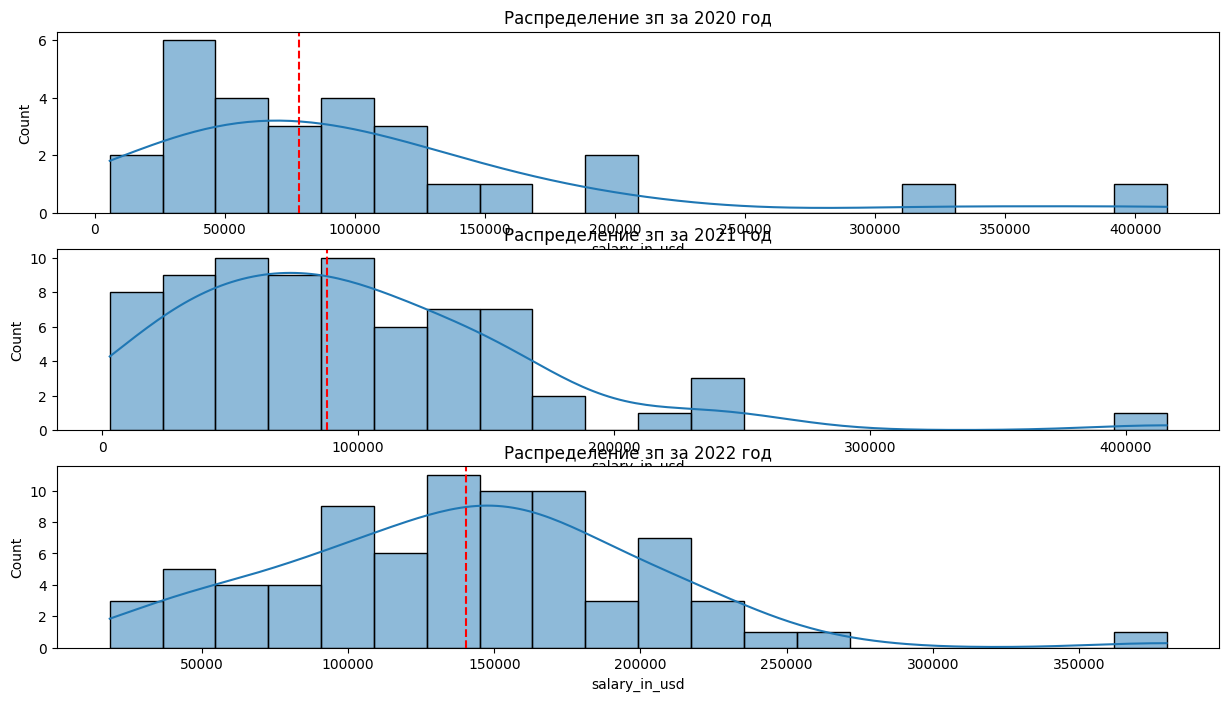

In [11]:
# Распределение зп по годам
fig, axes = plt.subplots(3, 1, figsize=(15, 8))

year_2020 = sns.histplot(
    data=ds_data[ds_data['work_year'] == 2020]['salary_in_usd'].to_frame(),
    x='salary_in_usd',
    bins=20,
    kde=True,
    ax=axes[0]
)
year_2020.set_title('Распределение зп за 2020 год');
year_2020.axvline(
    ds_data[ds_data['work_year'] == 2020]['salary_in_usd'].median(),
    color='red',
    linestyle='--');

year_2021 = sns.histplot(
    data=ds_data[ds_data['work_year'] == 2021]['salary_in_usd'].to_frame(),
    x='salary_in_usd',
    bins=20,
    kde=True,
    ax=axes[1]
)
year_2021.set_title('Распределение зп за 2021 год');
year_2021.axvline(
    ds_data[ds_data['work_year'] == 2021]['salary_in_usd'].median(),
    color='red',
    linestyle='--');

year_2022 = sns.histplot(
    data=ds_data[ds_data['work_year'] == 2022]['salary_in_usd'].to_frame(),
    x='salary_in_usd',
    bins=20,
    kde=True,
    ax=axes[2]
)
year_2022.set_title('Распределение зп за 2022 год');
year_2022.axvline(
    ds_data[ds_data['work_year'] == 2022]['salary_in_usd'].median(),
    color='red',
    linestyle='--');

In [12]:
# посмотрим на числовые значения
salary_description = ds_data.groupby('work_year')['salary_in_usd'].describe().round()
salary_description

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,28.0,102948.0,89203.0,5707.0,44869.0,78396.0,118500.0,412000.0
2021,73.0,96398.0,69450.0,2859.0,49646.0,87738.0,130026.0,416000.0
2022,78.0,139941.0,61628.0,18442.0,100000.0,140400.0,176750.0,380000.0


Вывод по визуализации распределения зарплат по годам:

Распределение за все 3 года не выглядят нормальными, выборка за 2020 год имеет существенно меньшее количество записей относительно 21-22 годов. На всех графиках присутствуют выбросные значения. С 20 на 21 год медианные значения выросли приблизительно на 10к, средние снизились на 6к. C 21 на 22 год медиана и среднее выросли приблизительно на 35 и 50 процентов соответственно. Мало оснований предполагать что средние зп выростают ежегодно, но они есть

2.1.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [13]:
# Список подходящих позиций
expression = re.compile("(?i)(\W|^)(Data Engineer|Data Engineering)(\W|$)")
eng_titles = list(filter(expression.search, main_data['job_title'].unique()))

# настроим маски для фильтрации датасета
mask_1 = main_data['job_title'] == 'Big Data Engineer'
mask_2 = main_data['job_title'] == 'Lead Data Engineer'
mask_3 = main_data['job_title'] == 'Data Engineer'
mask_4 = main_data['job_title'] == 'Data Engineering Manager'
mask_5 = main_data['job_title'] == 'Cloud Data Engineer'
mask_6 = main_data['job_title'] == 'Director of Data Engineering'
mask_7 = main_data['job_title'] == 'Principal Data Engineer'

# датасет для визуализации распределения зарплат Data Engineer
eng_data = main_data[mask_1 | mask_2 | mask_3 | mask_4 | mask_5 | mask_6 | mask_7]

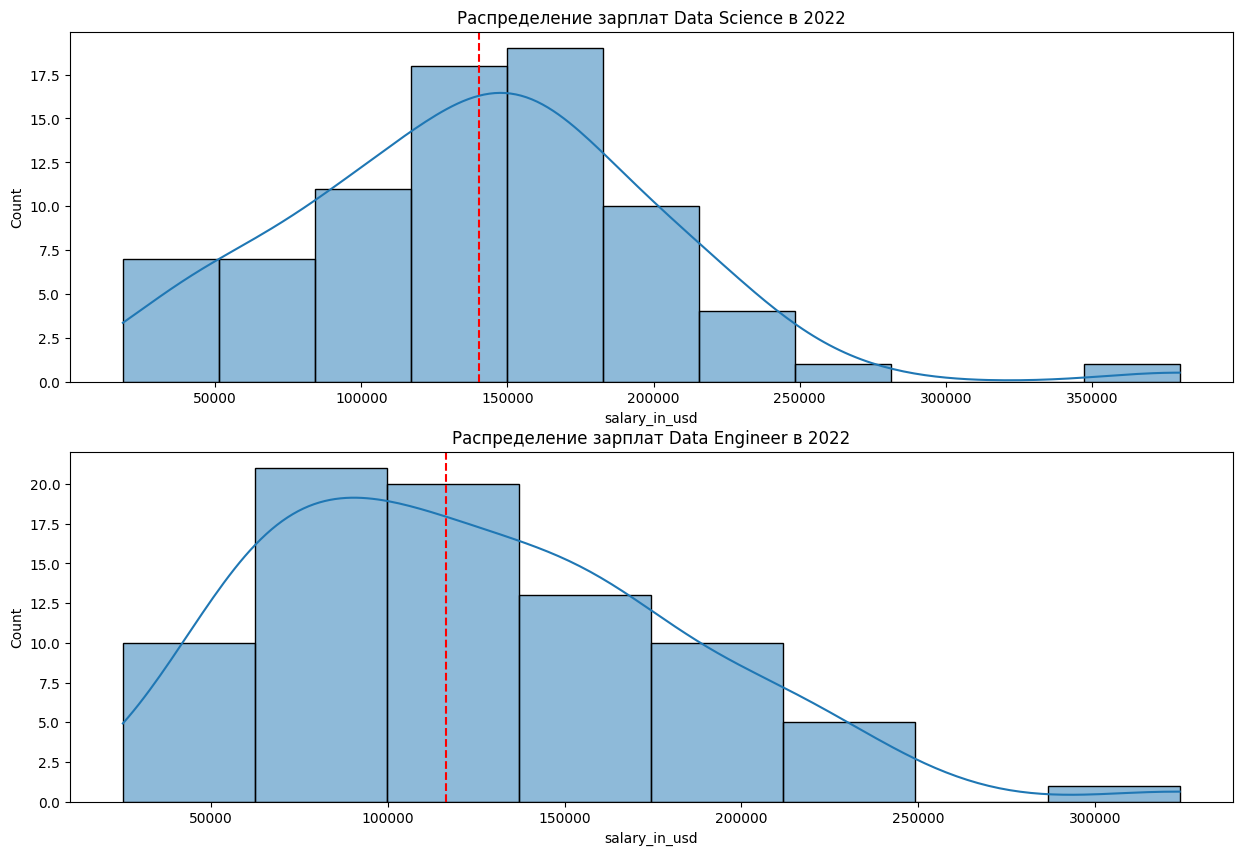

In [14]:
# График соотношения распределений зарплат Data Science - Data Engineer
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

ds_plot = sns.histplot(
    data=ds_data[ds_data['work_year'] == 2022],
    x='salary_in_usd',
    kde=True,
    ax=axes[0]
)
ds_plot.set_title('Распределение зарплат Data Science в 2022');
ds_plot.axvline(
    ds_data[ds_data['work_year'] == 2022]['salary_in_usd'].median(),
    color='red',
    linestyle='--'
    );

eng_plot = sns.histplot(
    data=eng_data[eng_data['work_year'] == 2022],
    x='salary_in_usd',
    kde=True,
    ax=axes[1]
)
eng_plot.set_title('Распределение зарплат Data Engineer в 2022');
eng_plot.axvline(
    eng_data[eng_data['work_year'] == 2022]['salary_in_usd'].median(),
    color='red',
    linestyle='--'
    );

Посмотрим на распределение признаков в цифрах

In [15]:
# для дата-сайнтистов
ds_salary_describe = ds_data[
    ds_data['work_year'] == 2022
    ]['salary_in_usd'].describe().round().to_frame()
display(ds_salary_describe)

# для дата инженеров
eng_salary_describe = eng_data[
    eng_data['work_year'] == 2022
    ]['salary_in_usd'].describe().round().to_frame()
display(eng_salary_describe)

,salary_in_usd
count,78.0
mean,139941.0
std,61628.0
min,18442.0
25%,100000.0
50%,140400.0
75%,176750.0
max,380000.0


,salary_in_usd
count,80.0
mean,124571.0
std,57484.0
min,25000.0
25%,78526.0
50%,116394.0
75%,160020.0
max,324000.0


Вывод по визуальному анализу: 
Признаки не распределениы нормально, значения медиан и средних зарплат на 2022 год у дата-сайнтистов превышают значения зарплат для дата-инженеров

2.1.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

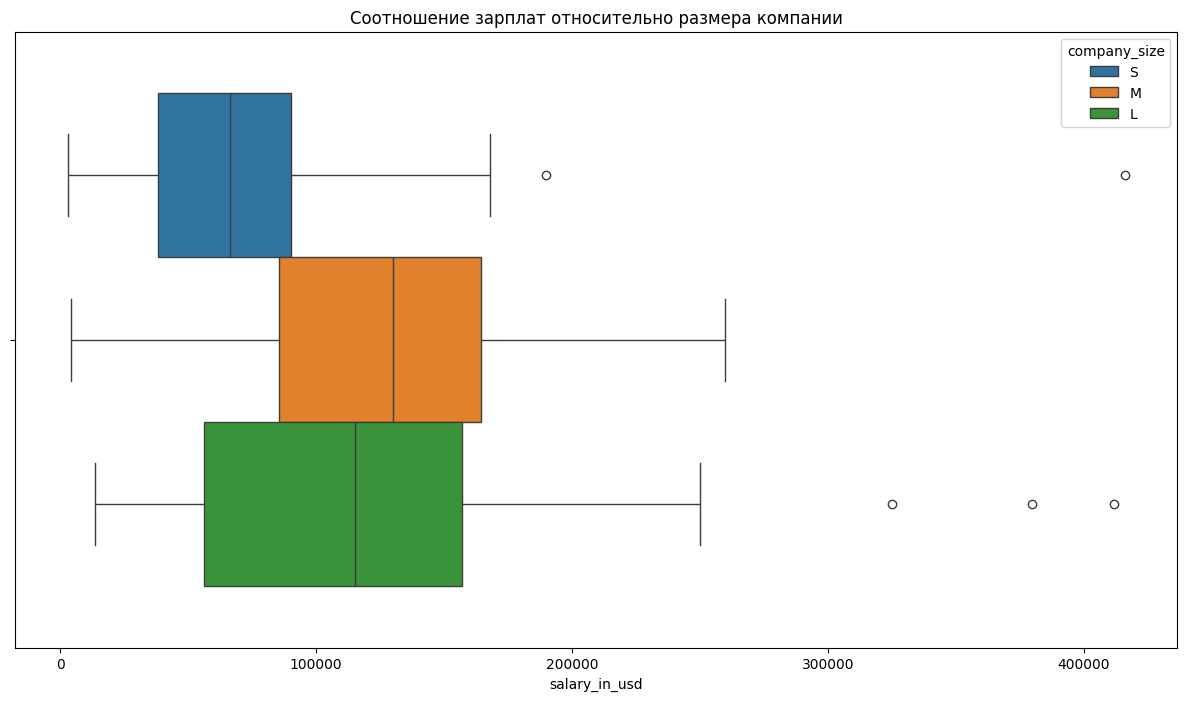

In [16]:
fig = plt.figure(figsize=(15, 8))

# посмотирим на распределения применив коробчатую диаграмму
box = sns.boxplot(
    data=ds_data,
    x='salary_in_usd',
    hue='company_size',
    hue_order=['S', 'M', 'L'],
    orient='h'
)
box.set_title('Соотношение зарплат относительно размера компании');

In [17]:
# Посмотрим на распределения в цифрах
ds_data.groupby('company_size')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,69.0,121956.0,80842.0,13400.0,56256.0,115000.0,157000.0,412000.0
M,82.0,124500.0,57571.0,4000.0,85426.0,130000.0,164418.0,260000.0
S,28.0,78965.0,79917.0,2859.0,38031.0,66234.0,90309.0,416000.0


Выводы по визуализации: 
Распределения не выглядят нормальными, за исключением средних компаний, присутствует разница по количеству записей в выборках. В малых компаниях основные статистические параметры явно ниже. А вот в средних и крупных компаниях значения сопоставимы, за исключением максимальных значений, они в крупных компаниях на порядок выше

2.1.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [18]:
# для двух ранее отфильтрованых датафреймов создадим
# объединяющий признак по должностям
ds_data['bin'] = 'scientist'
eng_data['bin'] = 'engineer'

# соединим таблицы
x = pd.concat([ds_data, eng_data])

# строим таблицу сопряжённости
cross = pd.crosstab(x['company_size'], x['bin'])

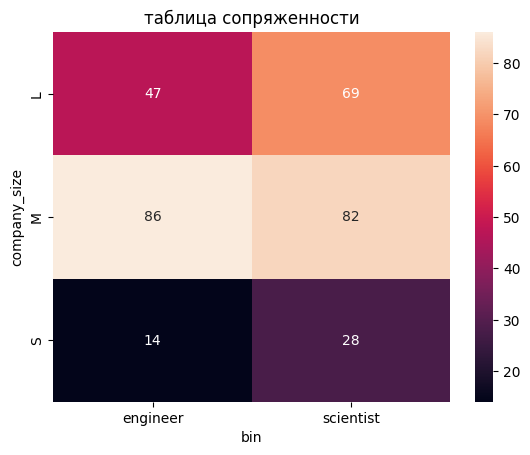

In [19]:
heat = sns.heatmap(
    cross,
    annot=True
)
heat.set_title('таблица сопряженности');

Выводы по категориальным признакам сделаем после статистических тестов

### Проведём дополнительные исследования признаков влияющих на зарплату специалистов

2.1.5 Как соотносятся зарплаты сотрудников любых должностей в разрезе опыта

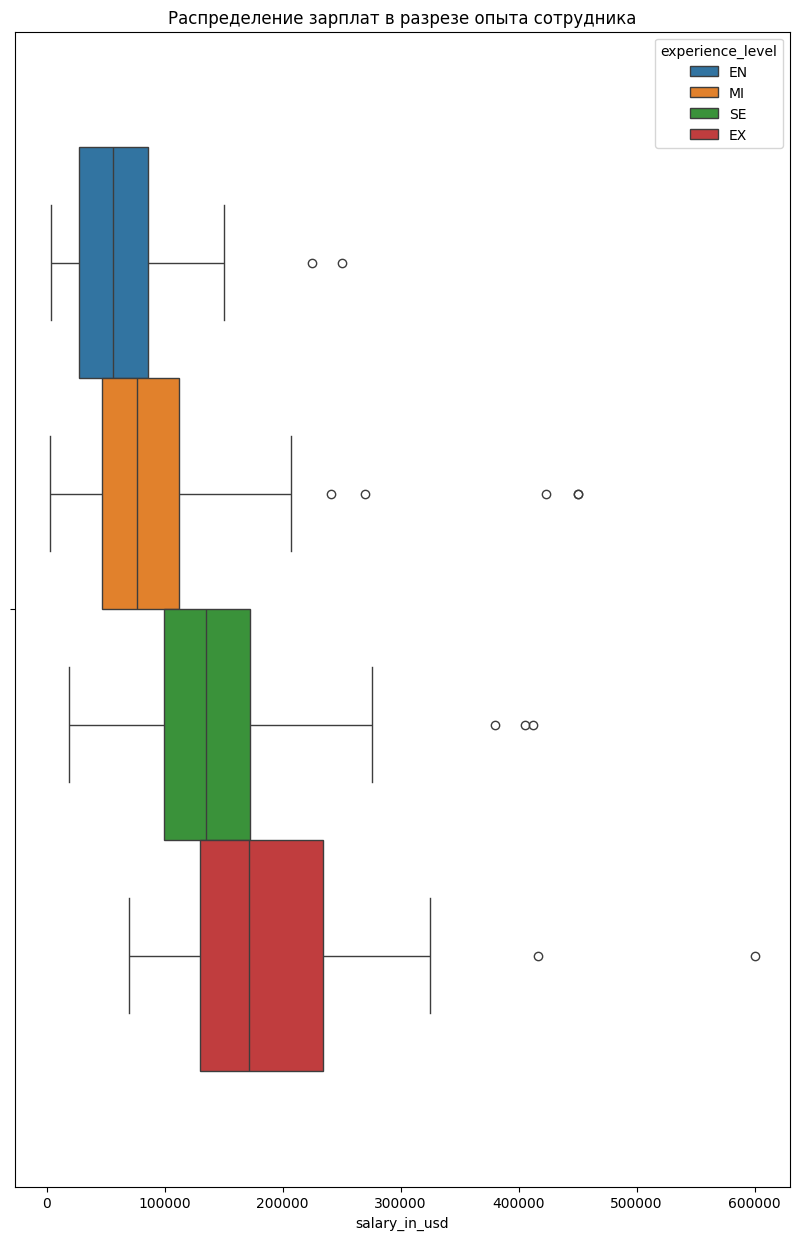

In [20]:
fig = plt.figure(figsize=(10, 15))

box = sns.boxplot(
    main_data,
    x='salary_in_usd',
    hue='experience_level',
    hue_order=['EN', 'MI', 'SE', 'EX']
)
box.set_title('Распределение зарплат в разрезе опыта сотрудника');

In [21]:
main_data.groupby(
    'experience_level'
    )['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.0,44396.0,4000.0,27505.0,56500.0,85426.0,250000.0
EX,26.0,199392.0,117071.0,69741.0,130006.0,171438.0,233750.0,600000.0
MI,208.0,87793.0,64119.0,2859.0,47164.0,76940.0,112075.0,450000.0
SE,243.0,138375.0,59956.0,18907.0,99532.0,135000.0,171881.0,412000.0


Выводы по визуализации:
Средние и медианы признаков довольно существенно различаются, признаки не распределены нормально

2.1.6 Посмотрим на то как влияет национальная (здесь в разрезе региона) принадлежность на уровень зарплаты

In [22]:
# считаем xml - таблицу с кодами стран
countries = pd.read_xml(
    'https://www.artlebedev.ru/country-list/xml/'
    )

# соединим нашу основную таблицу и таблицу с кодами стран,
# чтоб получить соответствие региону
data_w_countries = main_data.merge(
    countries,
    how='left',
    left_on='employee_residence',
    right_on='alpha2'
    )

# удалим ненужные столбцы
data_w_countries = data_w_countries.drop(
    [
    'fullname', 'name', 'alpha2', 'alpha3', 'iso', 'location-precise'
    ], 
    axis=1
    )

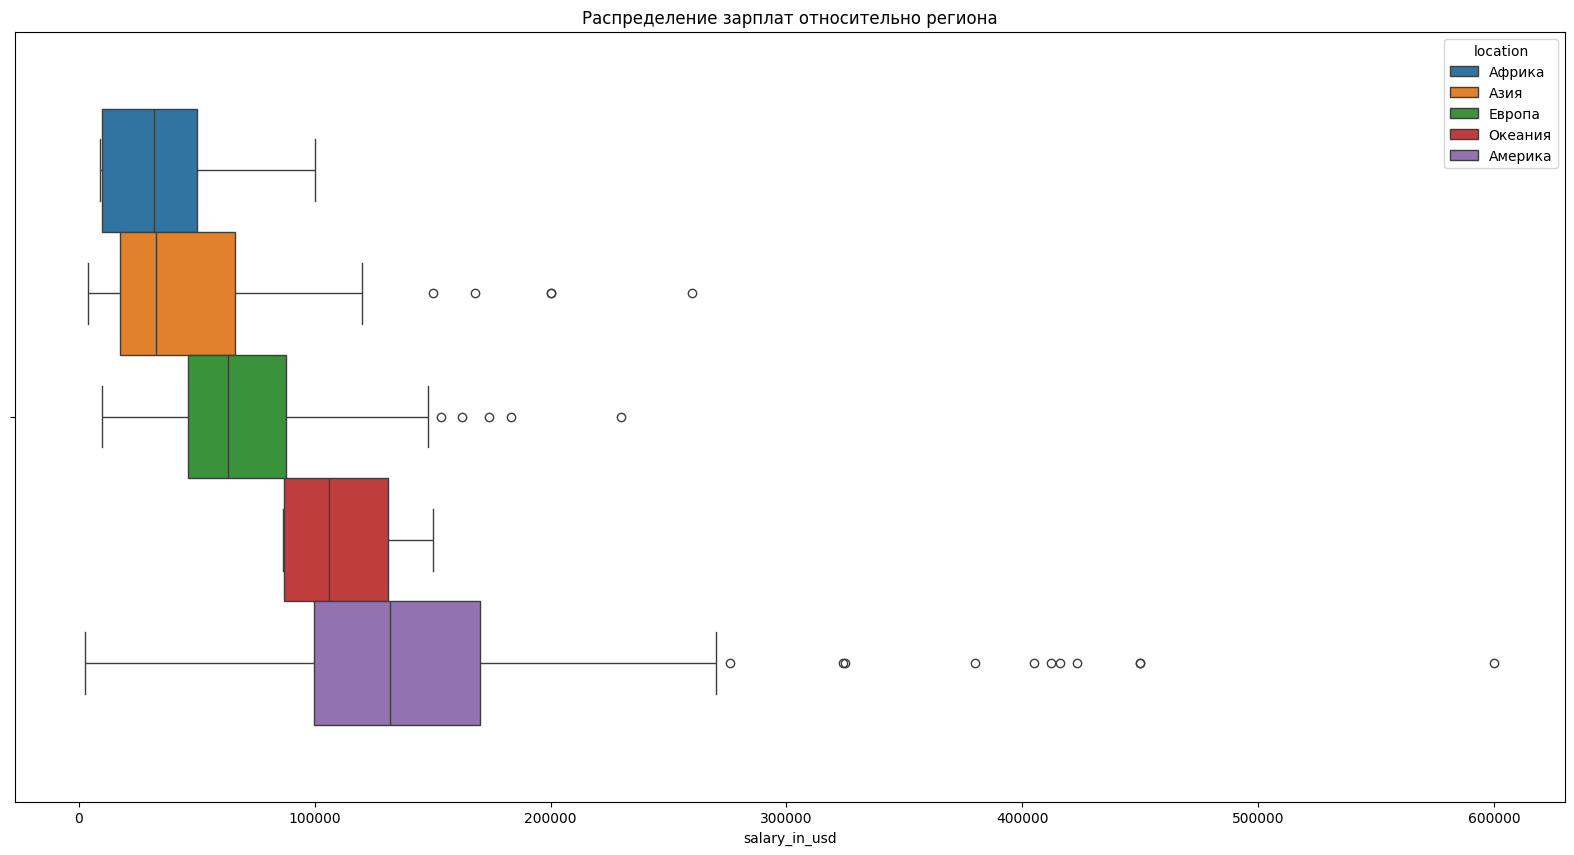

In [23]:
fig = plt.figure(figsize=(20, 10))

box = sns.boxplot(
    data_w_countries,
    x='salary_in_usd',
    hue='location',
    orient='h',
    hue_order=['Африка', 'Азия', 'Европа', 'Океания', 'Америка'] 
)
box.set_title('Распределение зарплат относительно региона');

In [24]:
data_w_countries.groupby('location')['salary_in_usd'].describe().round()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Азия,60.0,52156.0,54233.0,4000.0,17766.0,32712.0,66083.0,260000.0
Америка,336.0,141795.0,72095.0,2859.0,99926.0,132160.0,170000.0,600000.0
Африка,5.0,40229.0,37450.0,9272.0,10000.0,31875.0,50000.0,100000.0
Европа,160.0,69200.0,34793.0,10000.0,46422.0,63278.0,87932.0,230000.0
Океания,4.0,112282.0,30857.0,86703.0,87244.0,106212.0,131250.0,150000.0


Выводы по визуальному анализу распределения зарплат в разрезе принадлежности:
Придётся убрать из исследования выборки по Африке и Океании (Н. Зеландия, Австралия), по причине недостаточности. Средние отличаются почти в 3 раза между Азией и Америкой, разница по медианам ещё больше. Распределения не кажутся нормальными, но выборка по Америке близка к нормальному распределению.

## Статистические тесты

In [25]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))
    
# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


***3.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?***

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплата за предыдущий год ($μ_1$) статистически больше либо равна размеру зарплаты следующего года ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): зарплата за предыдущий год ($μ_1$) статистически меньше, чем размер зарплаты следующего года ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [26]:
# запишем выборки
y2020 = ds_data[ds_data['work_year'] == 2020]['salary_in_usd']
y2021 = ds_data[ds_data['work_year'] == 2021]['salary_in_usd']
y2022 = ds_data[ds_data['work_year'] == 2022]['salary_in_usd']

# проводим тесты
_, p = stats.shapiro(y2020)
decision_normality(p)

_, p = stats.shapiro(y2021)
decision_normality(p)

_, p = stats.shapiro(y2022)
decision_normality(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Несмотря на 3 сравниваемые группы, изначально было решено провести два последовательных теста, так-как нужно ответить на вопрос о ежегодном росте. Тип признака - количественный, группы независимы и не распределены нормально.

Нам подойдёт U-критерий Манна — Уитни.

**Проведём тесты**

In [27]:
# Проверим теорию "ЗП в 2021 году больше чем в 2020"
_, p = stats.mannwhitneyu(y2020, y2021, alternative='less')
decision_hypothesis(p)

# Проверим теорию "ЗП в 2022 году больше чем в 2021"
_, p = stats.mannwhitneyu(y2021, y2022, alternative='less')
decision_hypothesis(p)

p-value = 0.455
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод по стат тесту: ***Нет оснований*** утверждать, что наблюдается ежегодный рост зарплат у специалистов Data Science, т.к. в сравнении 2020 и 2021 годов у нас не было оснований отвергнуть нулевую гипотезу

***3.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?***

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплаты специалистов Data Scintist ($μ_1$) не отличается от размера зарплаты специалистов Data Engineer ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): зарплаты специалистов Data Scintist ($μ_1$) не равны размерам зарплат специалистов Data Engineer ($μ_2$).

$$ H_1 : μ_1 \neq μ_2$$

**Проверка на нормальность**

In [28]:
# Проверка на нормальность распределения зарплат для
# Data Science за 2022 год
_, p = stats.shapiro(
    ds_data[ds_data['work_year'] == 2022]['salary_in_usd']
    )
decision_normality(p)

# Проверка на нормальность распределения зарплат для
# Data Engineer за 2022 год
_, p = stats.shapiro(
    eng_data[eng_data['work_year'] == 2022]['salary_in_usd']
    )
decision_normality(p)

p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Присутствует две независимые группы. Тип признака - количественный, группы не распределены нормально.

Нам подойдёт U-критерий Манна — Уитни.

**Проведём тесты**

In [29]:
_, p = stats.mannwhitneyu(
    ds_data[ds_data['work_year'] == 2022]['salary_in_usd'],
    eng_data[eng_data['work_year'] == 2022]['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.069
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: Зарплаты Data Science специалистов ***равны*** зарплатам специалистов Data Engineer

***3.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?***

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплаты специалистов Data Scintist не отличаются в зависимости от размера компании: "S": ($μ_1$), "M": ($μ_2$), "L": ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): зарплаты специалистов Data Scintist отличаются в зависимости от размера компании: "S": ($μ_1$), "M": ($μ_2$), "L": ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

In [30]:
# проверка малых компаний на нормальное распределение
_, p = stats.shapiro(
    ds_data[ds_data['company_size'] == 'S']['salary_in_usd']
    )
decision_normality(p)

# проверка средних компаний на нормальное распределение
_, p = stats.shapiro(
    ds_data[ds_data['company_size'] == 'M']['salary_in_usd']
    )
decision_normality(p)

# проверка больших компаний на нормальное распределение
_, p = stats.shapiro(
    ds_data[ds_data['company_size'] == 'L']['salary_in_usd']
    )
decision_normality(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.785
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

У нас 3 количественные, независимые группы, в двух распределение не является нормальным.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [31]:
_, p = stats.kruskal(
    ds_data[ds_data['company_size'] == 'S']['salary_in_usd'],
    ds_data[ds_data['company_size'] == 'M']['salary_in_usd'],
    ds_data[ds_data['company_size'] == 'L']['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: в компаниях различного размера ***отличаются*** распределения зарплат

***3.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?***

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: взаимосвязи между наличием должностей Data Scientist и Data Engineer и размером компании нет (признаки независимы).

*Альтернативная гипотеза*: взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании есть (признаки зависимы).

**Выберем подходящий статистический тест**

У нас одна группа, в которой мы проверяем зависимость между двумя признаками

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [32]:
_, p, _, _ = stats.chi2_contingency(cross)
decision_hypothesis(p)

p-value = 0.054
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: ***нет связи*** между наличием должностей Data Scientist и Data Engineer и размером компании

***3.5 Как соотносятся зарплаты сотрудников любых должностей в разрезе опыта***

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплаты специалистов не отличаются в зависимости от опыта сотрудника: "ЕN": ($μ_1$), "MI": ($μ_2$), "SE": ($μ_3$), "EX": ($μ_4$)

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$): зарплаты специалистов отличаются в зависимости от опыта сотрудника: "ЕN": ($μ_1$), "MI": ($μ_2$), "SE": ($μ_3$), "EX": ($μ_4$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

**Проверка на нормальность**

In [33]:
# проверим распределение зарплат специалстов уровня "EN"
_, p = stats.shapiro(
    main_data[main_data['experience_level'] == 'EN']['salary_in_usd']
)
decision_normality(p)

# проверим распределение зарплат специалстов уровня "MI"
_, p = stats.shapiro(
    main_data[main_data['experience_level'] == 'MI']['salary_in_usd']
)
decision_normality(p)

# проверим распределение зарплат специалстов уровня "SE"
_, p = stats.shapiro(
    main_data[main_data['experience_level'] == 'SE']['salary_in_usd']
)
decision_normality(p)

# проверим распределение зарплат специалстов уровня "EX"
_, p = stats.shapiro(
    main_data[main_data['experience_level'] == 'EX']['salary_in_usd']
)
decision_normality(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

У нас четыре числовых, независимых группы, с распределением отличным от нормального

Для проверки нашей гипотезы можно использовать критерий Краскела-Уоллиса.

**Проведём тест**

In [34]:
_, p = stats.kruskal(
    main_data[main_data['experience_level'] == 'EN']['salary_in_usd'],
    main_data[main_data['experience_level'] == 'MI']['salary_in_usd'],
    main_data[main_data['experience_level'] == 'SE']['salary_in_usd'],
    main_data[main_data['experience_level'] == 'EX']['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: зарплаты **отличаются** в зависимости от опыта сотрудника

***3.6 Отличаются ли зарплаты у специалистов разных стран?***

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат специалистов из региона "Америка" ($μ_1$) статистически меньше либо равен размеру зарплат специалистов из региона "Азия" ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат специалистов из региона "Америка" ($μ_1$) статистически больше, чем размер зарплат специалистов из региона "Азия" ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

In [35]:
# проверим распределение зарплат специалистов из решиона "Америка"
_, p = stats.shapiro(
    data_w_countries[
        data_w_countries['location'] == 'Америка'
        ]['salary_in_usd']
)
decision_normality(p)

# проверим распределение зарплат специалистов из решиона "Азия"
_, p = stats.shapiro(
    data_w_countries[
        data_w_countries['location'] == 'Азия'
        ]['salary_in_usd']
)
decision_normality(p)


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Присутствует две независимые группы. Тип признака - количественный, группы не распределены нормально.

Нам подойдёт U-критерий Манна — Уитни.

**Проведём тест**

In [36]:
_, p = stats.mannwhitneyu(
    data_w_countries[
        data_w_countries['location'] == 'Америка'
        ]['salary_in_usd'],
    data_w_countries[
        data_w_countries['location'] == 'Азия'
        ]['salary_in_usd'],
    alternative='greater'
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: В регионе "Америка" зарплаты выше чем в регионе "Азия", соответственно зарплаты различаются в зависимости от региона

## Итоги

*1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?*
* Нет, ежегодного роста не наблюдается, т.к. по результатам статистических тестов в 2020 году зарплаты были статистически равны или больше чем в 2021 году

*2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?*
* Зарплаты этих двух направлений статистически равны

*3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?*
* Зарплаты различаются в зависисимости от размера компании. Можно предположить, что это обосновано более широким штатом сотрудников, большим количеством старшего управленческого звена и более высококвалифицироваными сотрудниками (но это не точно)

*4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?*
* Связи между наличием обоих позиций и размером компании нет. Возможно, по причине сепарации специальностей в области DS, что увиличивает результативность работы

*5. Как соотносятся зарплаты сотрудников любых должностей в разрезе опыта*
* Зарплаты специалистов разного опыта различаются, но это вполне ожидаемо

*6. Как соотносятся зарплаты специалистов из разных регионов?
*
* Зарплаты различаются. Что тоже вполне ожидаемо и очевидно, например мы сравнили зарплаты регионов "Америка" и "Азия", соответственно в первом случае зарплаты кратно выше. Это связано с технологическим прогрессом компаний из этих стран и законодательствами этих стран устанавливающих политику оплаты труда.